# Fine Tuning DistilBERT for Multiclass Text Classification

## Dataset Link - https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

In [1]:
!pip  install transformers==4.22.1 -q

In [39]:
import sklearn, transformers

print("sklearn:", sklearn.__version__)
print("transformers:", transformers.__version__)

sklearn: 1.2.2
transformers: 4.22.1


In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification  # error -> click on "modeling_tf_utils.py"  -> comment : "from keras.saving.hdf5_format import ..."
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [4]:
file_path = 'bbc-text.csv'

In [5]:
df = pd.read_csv(file_path)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.shape

(2225, 2)

# Show number of collected data by categories

In [7]:
category_count = df['category'].value_counts()
category_count

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

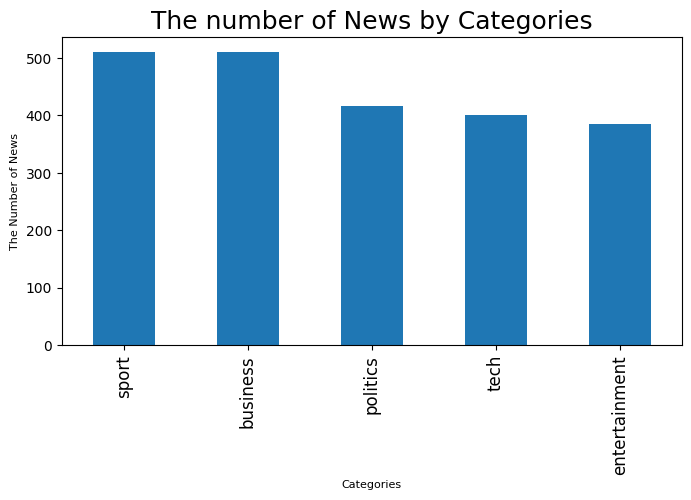

In [17]:
fig = plt.figure(figsize= (8, 4))

ax = fig.add_subplot(111)

category_count.plot.bar(x = category_count.index, y = category_count)

# for a, p in enumerate(ax.patches):
#     ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 8)
plt.ylabel('The Number of News', size= 8)


plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [13]:
df['label'] = df['category'].astype('category').cat.codes
df.head(10)

,category,text,label
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1
5,politics,howard hits back at mongrel jibe michael howar...,2
6,politics,blair prepares to name poll date tony blair is...,2
7,sport,henman hopes ended in dubai third seed tim hen...,3
8,sport,wilkinson fit to face edinburgh england captai...,3
9,entertainment,last star wars not for children the sixth an...,1


In [18]:
data_texts = df['text'].to_list()
data_labels = df['label'].to_list()

# Train Test SPlit

In [19]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )



# Model Definition

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [22]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

/usr/local/lib/python3.10/dist-packages/transformers/trainer_tf.py:115: FutureWarning:

The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow



**The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object.**

So we have to do it manually.

---
FIRST WE SET THE MAIN BERT ARCHITECHTURE TO NON-TRAINABLE. BECAUSE WE ONLY WANT TO FINE-TUNE THE LAST LAYERS.

In [23]:
layers = model.layers
layers

In [24]:
layers[0].trainable = False

In [25]:
layers[0].trainable

False

In [26]:
[l.trainable for l in model.layers]

[False, True, True, True]

In [27]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


---

# Compile and fit

In [ ]:
model.compile(optimizer="adam")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=3, batch_size=64)

Epoch 1/3
1762/1762 [==============================] - 2714s 2s/step - loss: 0.2867 - val_loss: 0.2099
Epoch 2/3
1762/1762 [==============================] - 2766s 2s/step - loss: 0.1663 - val_loss: 0.1600
Epoch 3/3
1762/1762 [==============================] - 2762s 2s/step - loss: 0.1224 - val_loss: 0.0376


With a basic Google Colab account:

**Trainning Time:** 2h 30m

# Saving & Loading the model

In [28]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/fine-tune-distilbert"

In [ ]:
model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert/added_tokens.json')

# Loading Pre-Trained Model

In [30]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert and are newly initialized: ['

In [31]:
pipeline = TextClassificationPipeline(model=model_fine_tuned, tokenizer=tokenizer_fine_tuned)

In [32]:
len(test_texts)

18

## Make some predictions

In [33]:
def predict_sample(n, show=True):
  assert n < 18
  test_text  = test_texts[n]
  label = test_labels[n]
  pred = pipeline(test_text)

  if show:
    print(f"\nSample {n}\n-----------")
    print("Prediction:", pred)
    print("Real label:", label)

  return label, pred

In [34]:
predict_sample(4)


Sample 4
-----------
Prediction: [{'label': 'LABEL_1', 'score': 1.0}]
Real label: 1


(1, [{'label': 'LABEL_1', 'score': 1.0}])

In [35]:
import matplotlib.pyplot as plt
import numpy as np

Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors


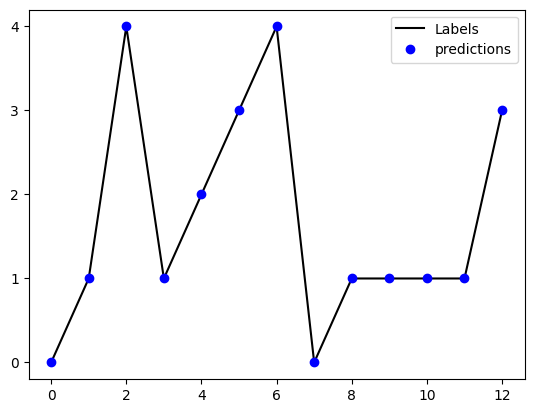

In [36]:
real_values = []
predictions = []

for n in range(len(test_texts)):
  try:
    label, pred = predict_sample(n, show=False)
    pred = int(pred[0]["label"][-1])
    real_values.append(label)
    predictions.append(pred)
  except:
    pass

x = range(1, len(predictions)+1)
plt.plot(real_values, "k-", label="Labels")
plt.plot(predictions, "bo", label="predictions")
plt.yticks([0,1,2,3,4])
plt.legend()
plt.show()

Seems like we have a 100% accuracy. Lets check some real metrics from keras.

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

array([[2, 0, 0, 0, 0],
       [0, 6, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2]])

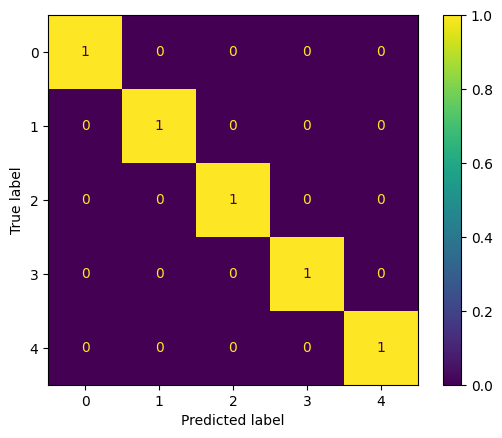

In [38]:
cm = confusion_matrix(real_values, predictions)
cm2 = np.array([cm[i]/cm[i].sum() for i in range(len(cm))])

cm_display = ConfusionMatrixDisplay(cm2).plot()
cm

100% accuracy in the test sample!

## Finally we can check a summary of our model

In [ ]:
model_fine_tuned.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_fine_tuned.layers[0].config

DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/Multi-class-text-classifica_fine-tuning-distilbert",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.1",
  "vocab_size": 30522
}

### Manual execution

```python
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value
```